In [1]:
from functions import *
from models import *

2024-11-01 14:24:16.069316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-01 14:24:16.090940: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-01 14:24:16.097511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-01 14:24:16.114211: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-01 14:24:17.277851: W tensorflow/compiler/tf2

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import time
from datetime import datetime

## Load data

In [17]:
# Set variables
source_folder = '../data/external/raster_masks'
rivers = {}
source_path = '../data/preprocessed/'
data_paths = ['lst','wt','ndvi','slope', 'discharge']#,'wt','ndvi','slope', 'discharge','masked']#,'slope', 'discharge']#, 'ndvi', 'wt', 'masked','discharge', 'slope']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k:[] for k in data_paths}    
total_data = {}
total_times = {}
complete_rivers = []
filter_river = None
W=256
time_split = True

# Load rivers
for subdir, dirs, files in os.walk(source_folder):
    for i,file in enumerate(files):
        r,m = load_raster(os.path.join(subdir, file), False)
        name = file.split('.')[0].split('bw_')[-1]
        rivers[name] = r

# Load input paths
for i,dir_p in enumerate(dir_paths):
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints'): 
            all_dir_paths[data_paths[i]].append(subdir)
        elif subdir.endswith('masked') and 'masked' in data_paths:
            all_dir_paths['masked'].append(subdir)


In [25]:
# Load input data
for k,v in all_dir_paths.items():
    if filter_river != None:
        v = [v[i] for i in filter_river]
    
    if k != 'discharge' and k != 'slope':
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)
            
        data, times = load_data(v,W,list_rgb)
        if k!='masked':
            labels = []
            for ki,value in data.items():
                labels+=[ki.split('/')[-1]]*len(value)
        
        data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
        times_list = [t for sublist in times for t in sublist]
   
        if time_split:
            dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
            pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
            sorted_dates, data_values, labels = zip(*pairs)
            times_list = [date.strftime('%Y-%m') for date in sorted_dates]
            
        total_data[k] = np.array(data_values)
        total_times[k] = times_list
        print(k,':' ,total_data[k].shape)

    elif k == 'discharge' or k == 'slope':
        total = []
        for p in v:
            for file in os.listdir(p):
                file_path = os.path.join(p, file)
                r,m = load_raster(file_path, False)
                var = resize_image(r, W,W)
                img_river = labels.count(p.split("/")[-1])
                var_input = np.tile(var, (img_river, 1, 1))
                if var_input.size !=0:
                    total.append(var_input)
        data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
        if time_split:
            dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
            pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
            sorted_dates, data_values, labels = zip(*pairs)
            times_list = [date.strftime('%Y-%m') for date in sorted_dates]
            
        total_data[k] = np.array(data_values)
        print(k,':' ,total_data[k].shape)

# Hot encoding
encoder = OneHotEncoder(sparse_output=False)
river_encoded = encoder.fit_transform(np.array(labels).reshape(-1, 1))
data_targets = total_data['wt']
results = {'MAE':0,'MSE':0,'RMSE':0,'R²':0,'MAPE (%)':0,'MSE sample-wise':0}


lst : (147, 256, 256, 3)
wt : (147, 256, 256)
ndvi : (147, 256, 256)
8
slope : (147, 256, 256)
8
discharge : (147, 256, 256)


## Do experiment

In [26]:
W = 256
filter_river = None#[3,11,12]
inputs = ['lst']#,'ndvi','discharge', 'slope']#['ndvi','discharge', 'slope']
conditioned = False
batch_size = 16
epochs = 10
model_name = "img_wise_CNN_improved" #img_wise_CNN, UNet, transfer_learning_VGG16, CNN, img_2_img
stratified = False
physics_guided = False

#### Choose model

In [27]:
def get_results(test_target, test_prediction, rivers, labels, test_index):
    mean_results = {k:[] for k in results.keys()}
    # Loop through each sample and compute the MSE for that sample
    for i in range(test_target.shape[0]):
        # Flatten the true and predicted values for this sample
        riv = rivers[labels[test_index[i]]].flatten()
        y_true_flatten = test_target[i].flatten()
        y_true_mask = y_true_flatten[riv != 0]
        y_pred_flatten = test_prediction[i].flatten()
        y_pred_mask = y_pred_flatten[riv != 0]
        # Calculate metrics
        res = evaluate_model(y_true_mask, y_pred_mask)
        for k,v in res.items():
            mean_results[k].append(v)
    for key in mean_results:
        mean_results[key] = np.mean(mean_results[key])
    return mean_results

In [28]:
# Choose inputs
inputs_d = [total_data[inp] for inp in inputs]
# List to store the processed additional images
expanded_images = []
# Expand dimensions for single-channel images, leave multi-channel images as they are
for img in inputs_d:
    if img.ndim == 3:  # Case where image is (n, 256, 256) (single-channel)
        expanded_images.append(np.expand_dims(img, axis=-1))  # Expand to add an extra channel
    elif img.ndim == 4:  # Case where image already has multiple channels (n, 256, 256, c)
        expanded_images.append(img)  # Leave the image as it is
# Concatenate all images along the last axis (channels)
combined_input = np.concatenate(expanded_images, axis=-1)
# The final combined input is stored in input_data
input_data = combined_input

### Split data

In [29]:
if time_split:
    train_ratio = 0.6
    val_ratio = 0.2
    test_ratio = 0.2
    
    # Calcular el tamaño de cada conjunto
    total_images = len(input_data)
    train_size = int(total_images * train_ratio)
    val_size = int(total_images * val_ratio)
    indices = np.arange(total_images)
    
    train_index = indices[:train_size]                       # Primeros índices para entrenamiento
    validation_index = indices[train_size:train_size + val_size]    # Siguientes índices para validación
    test_index = indices[train_size + val_size:]             # Últimos índices para prueba
   
elif stratified:
    train_index, validation_index, test_index = split_data_stratified(input_data, data_targets, labels)
else:
    train_index, validation_index, test_index = split_data(input_data, data_targets)
        
validation_input = input_data[validation_index, :] / 255.0  # Normalize inputs
validation_target = data_targets[validation_index, :]
validation_rivers = river_encoded[validation_index, :]
test_input = input_data[test_index, :] / 255.0  # Normalize inputs
test_target = data_targets[test_index, :]
test_rivers = river_encoded[test_index, :]
train_input = input_data[train_index, :] / 255.0  # Normalize inputs
train_target = data_targets[train_index, :]
train_rivers = river_encoded[train_index, :]
print(f"Train: {len(train_input)} imágenes, {train_input.shape}")
print(f"Val: {len(validation_input)} imágenes, {validation_input.shape}")
print(f"Test: {len(test_input)} imágenes, {test_input.shape}")
print(train_target.shape, validation_target.shape, test_target.shape)

train_dates = np.array(total_times['lst'])[train_index] 
validation_dates = np.array(total_times['lst'])[validation_index] 
test_dates = np.array(total_times['lst'])[test_index] 

Train: 88 imágenes, (88, 256, 256, 3)
Val: 29 imágenes, (29, 256, 256, 3)
Test: 30 imágenes, (30, 256, 256, 3)
(88, 256, 256) (29, 256, 256) (30, 256, 256)


In [30]:
print(train_dates)
print(validation_dates)
print(test_dates)

['2013-04' '2013-04' '2013-04' '2013-06' '2013-06' '2013-06' '2013-07'
 '2013-07' '2013-07' '2013-08' '2013-08' '2013-08' '2013-08' '2013-09'
 '2013-09' '2013-09' '2013-09' '2013-10' '2013-11' '2013-12' '2013-12'
 '2013-12' '2014-01' '2014-02' '2014-02' '2014-02' '2014-03' '2014-03'
 '2014-03' '2014-04' '2014-04' '2014-05' '2014-05' '2014-05' '2014-06'
 '2014-06' '2014-07' '2014-09' '2014-09' '2014-10' '2014-11' '2015-01'
 '2015-02' '2015-02' '2015-02' '2015-03' '2015-05' '2015-05' '2015-05'
 '2015-05' '2015-06' '2015-07' '2015-08' '2015-08' '2015-08' '2015-08'
 '2015-08' '2015-08' '2015-09' '2015-10' '2015-11' '2015-11' '2015-12'
 '2015-12' '2015-12' '2016-02' '2016-02' '2016-02' '2016-02' '2016-03'
 '2016-03' '2016-03' '2016-04' '2016-04' '2016-05' '2016-05' '2016-06'
 '2016-07' '2016-07' '2016-08' '2016-08' '2016-08' '2016-08' '2016-09'
 '2016-09' '2016-09' '2016-09' '2016-10']
['2016-11' '2016-11' '2016-12' '2016-12' '2016-12' '2016-12' '2017-01'
 '2017-03' '2017-03' '2017-03' '201

#### Select inputs and model

In [31]:
if len(train_input.shape) == 3:
    input_shape = train_input.shape[1:]+(1,)
else:
    input_shape = train_input.shape[1:]


# Adapt input to condition
if conditioned:
    input_args = (input_shape, river_encoded.shape[1])
    model_input = (train_input, train_rivers)
    val_model_input = [validation_input, validation_rivers]
    test_model_input = [test_input, test_rivers]
else:
    input_args = input_shape
    model_input = train_input
    val_model_input = validation_input
    test_model_input = test_input


In [32]:
# Start model
start_time = time.time()
if model_name == "img_wise_CNN":
    if conditioned:
        model = build_simplified_cnn_model_label(input_args[0], input_args[1])
    else:
        model = build_simplified_cnn_model(input_args)
elif model_name == 'CNN':
    model = build_cnn_model(input_args)
elif model_name == 'img_2_img':
    model = build_img_2_img_model(input_args)
elif model_name == 'UNet':
    model = build_unet(input_args)
elif model_name == 'transfer_learning_VGG16':
    train_input = train_input[:, :, :, :3]
    model = build_transfer_model((W, W, 3))
elif model_name == "img_wise_CNN_improved":
    model = build_simplified_cnn_model_improved(input_args)
        

/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Train model

In [33]:
print(f"Running experiment with model={model_name}, batch_size={batch_size}, epochs={epochs}")

# Train the model
if not physics_guided:
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    history = model.fit(model_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(val_model_input, validation_target))
else:
    dataset = tf.data.Dataset.from_tensor_slices((*model_input, train_target) if isinstance(model_input, tuple) else (model_input, train_target))

    dataset = dataset.batch(batch_size)
    optimizer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for batch in dataset:
            # Handle batch based on whether model_input is a tuple or a single dataset
            if isinstance(model_input, tuple):
                model_input_batch = batch[:-1]  # All except the last element (target_batch)
                target_batch = batch[-1]        # Last element is target_batch
            else:
                model_input_batch, target_batch = batch  # Direct unpacking for single dataset

            with tf.GradientTape() as tape:
                y_pred = model([*model_input_batch], training=True) if isinstance(model_input_batch, tuple) else model(model_input_batch, training=True)
                loss = conservation_energy_loss(target_batch, y_pred, model_input_batch, alpha=0.5, beta=0.5)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))


# Evaluate results
#validation_prediction = model.predict(val_model_input)
test_prediction = model.predict(test_model_input)

print('\nComputing result metrics...')
mean_results = get_results(test_target, test_prediction, rivers, labels, test_index)

# Get experiment data
end_time = time.time()
duration = round(end_time - start_time, 2)
current_date = datetime.now().strftime("%Y-%m-%d")
current_time = datetime.now().strftime("%H:%M:%S")


# Save model results
laabeel = 'label' if conditioned else 'no label'
var_inputs = '' if inputs == None else ', '.join(inputs)
variables = ', '.join([var_inputs, laabeel])
details = {'RMSE':mean_results['RMSE'],'Variables':variables,'Input': f'{len(np.unique(labels))} rivers', 'Output': 'wt', \
           'Resolution': W, 'nº samples': len(data_targets), 'Batch size': batch_size, 'Epochs': epochs, 'Date':current_date, \
           'Time':current_time, 'Duration': duration, 'Loss':  'Physics-guided' if physics_guided else 'RMSE'}

file_path = f"../results/{model_name}_results.xlsx"
save_excel(file_path, details, excel = 'Results')

mean_results['Model'] = model_name
file_path = f"../results/all_results.xlsx"
save_excel(file_path, mean_results, excel = 'Results')

print(f"Experiment {model_name} with batch_size={batch_size} and epochs={epochs} completed.\n")


Running experiment with model=img_wise_CNN_improved, batch_size=16, epochs=10
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 859ms/step - loss: 13.4631 - mae: 1.0748 - val_loss: 6.7283 - val_mae: 0.5424
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 13.9881 - mae: 1.1293 - val_loss: 6.7099 - val_mae: 0.5491
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 12.1156 - mae: 1.0361 - val_loss: 6.6847 - val_mae: 0.5604
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 13.1655 - mae: 1.0993 - val_loss: 6.6574 - val_mae: 0.5726
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 10.1216 - mae: 0.9447 - val_loss: 6.6263 - val_mae: 0.5897
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.6377 - mae: 1.0729 - val_loss: 6.5927 - val_mae: 0.6097
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 9.8938 - mae: 0.9728 - val_loss: 6.5611 - val_mae: 0.6338
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 10.9939 - mae: 1.0355 - val_loss: 6.5375 - val_mae: 

In [2]:
import pandas as pd
model_name = 'img_wise_CNN_improved'
pd.read_excel(f'../results/{model_name}_results.xlsx')

,RMSE,Variables,Input,Output,Resolution,nº samples,Batch size,Epochs,Date,Time,Duration,Loss
0,2.946396,"lst, no label",13 rivers,wt,256,147,16,10,2024-11-01,14:25:51,88.29,Physics-guided
1,2.942914,"lst, no label",13 rivers,wt,256,147,16,10,2024-11-01,14:41:34,82.32,RMSE
2,2.979774,"lst, ndvi, no label",13 rivers,wt,256,147,16,10,2024-11-01,15:49:23,83.43,Physics-guided
3,2.954929,"lst, ndvi, no label",13 rivers,wt,256,147,16,10,2024-11-01,15:50:48,84.18,RMSE
4,3.140461,"lst, ndvi, no label",13 rivers,wt,256,147,16,50,2024-11-01,15:52:44,116.17,Physics-guided
5,4.037401,"lst, ndvi, no label",13 rivers,wt,256,147,16,50,2024-11-01,15:54:14,89.69,RMSE
6,2.980762,"lst, ndvi, no label",13 rivers,wt,256,147,32,10,2024-11-01,15:55:32,77.04,Physics-guided
7,2.966236,"lst, ndvi, no label",13 rivers,wt,256,147,32,10,2024-11-01,15:56:56,83.55,RMSE
8,3.032131,"lst, ndvi, no label",13 rivers,wt,256,147,32,50,2024-11-01,15:58:38,102.06,Physics-guided
9,3.262798,"lst, ndvi, no label",13 rivers,wt,256,147,32,50,2024-11-01,16:00:07,88.61,RMSE


In [35]:
ds = pd.read_excel(f'../results/img_wise_CNN_results.xlsx')
for i,r in ds.iterrows():
    if r['Epochs']==10 and r['Batch size']==16:
        print(list(r))


[2.857109546661377, 'lst, ndvi, no label', '13 rivers', 'wt', 256, 147, 16, 10, '2024-11-01', '14:41:31', 80.09, 'Physics-guided']


## Visualize results

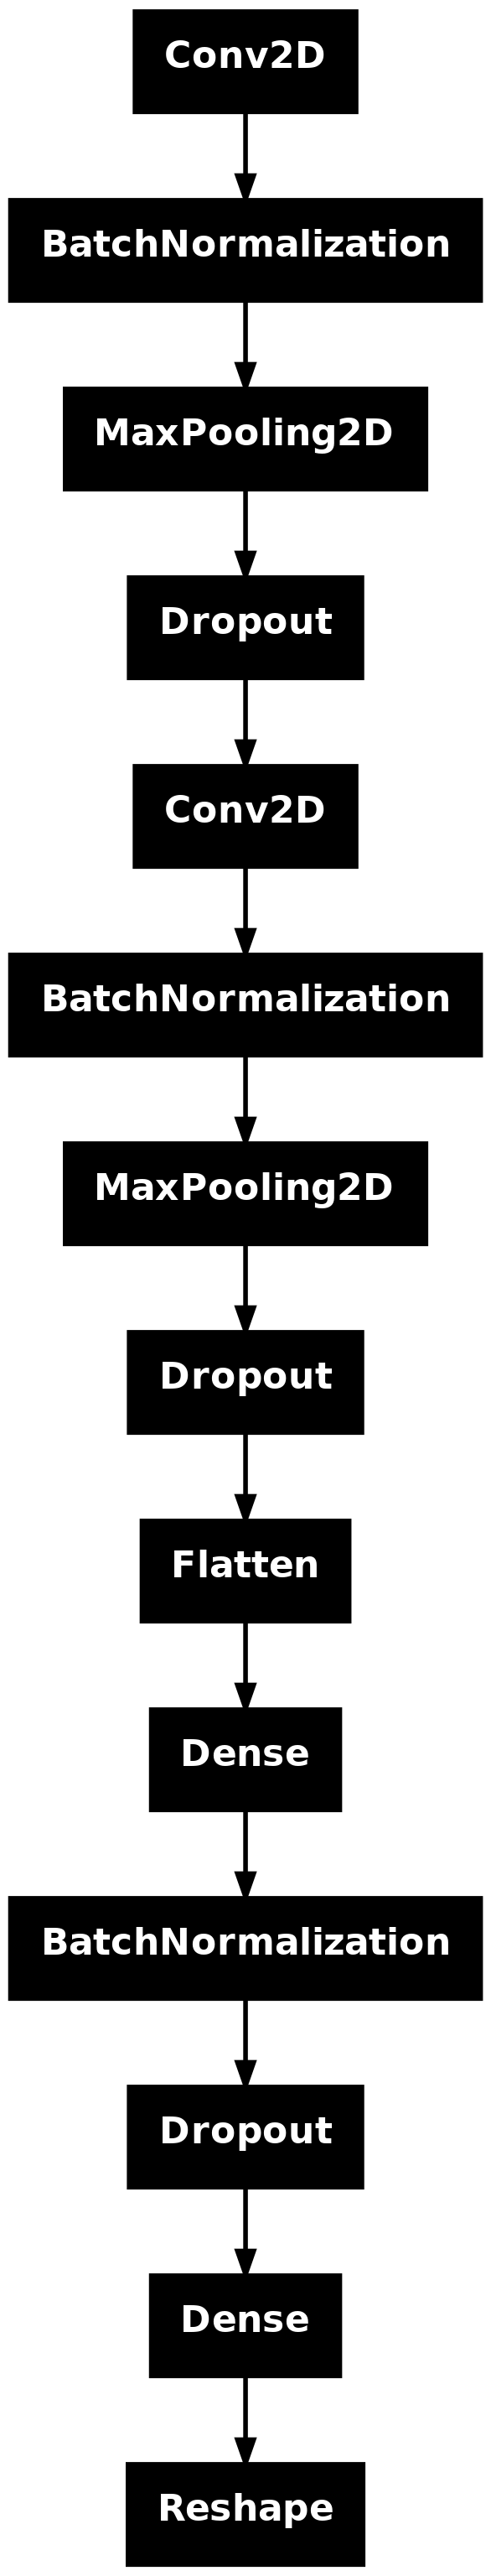

In [36]:
tf.keras.utils.plot_model(model)

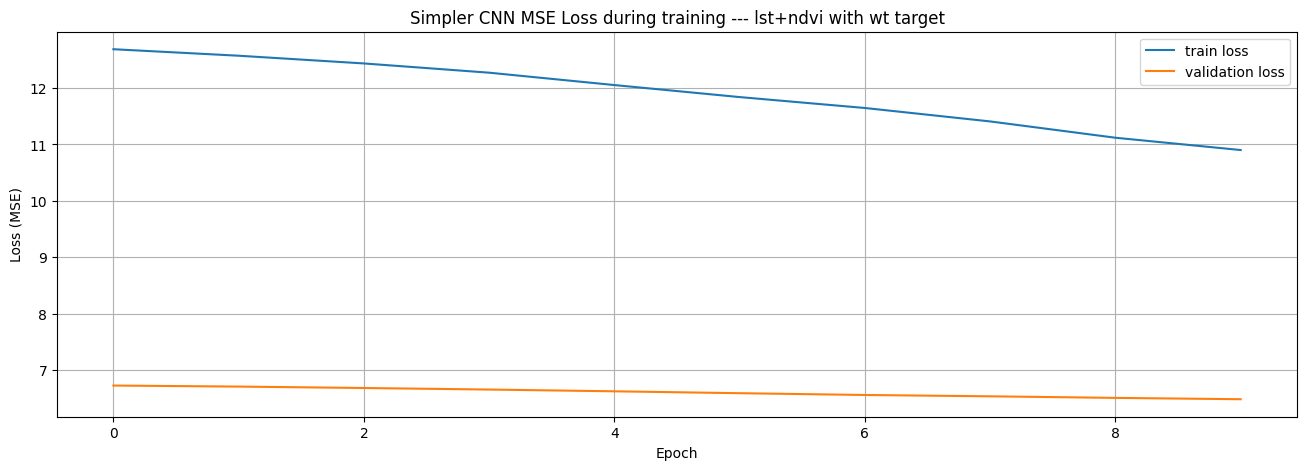

In [37]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

In [38]:
plt.savefig('../plots/cnn.png',dpi=100)

<Figure size 640x480 with 0 Axes>

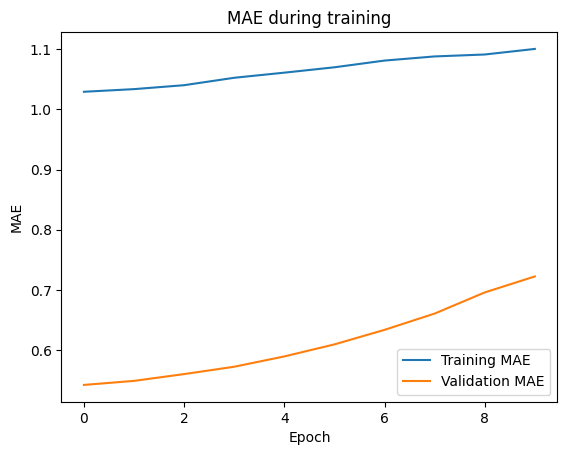

In [39]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Validate and test

Image wise metrics results

See what are the areas with more prediction error

In [40]:
if len(validation_prediction.shape) == 4:
  validation_prediction=np.squeeze(validation_prediction, axis=3)

diff = validation_prediction - validation_target
for i in range(diff.shape[0]):
  sns.heatmap(diff[i], cmap='coolwarm')
  plt.title('Prediction Error Heatmap')
  plt.show()

NameError: name 'validation_prediction' is not defined

Dispersion graph and histogram of prediction errors

In [ ]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que y_true son tus valores reales y y_pred son tus predicciones
y_true = validation_target_flat # Valores reales
y_pred = validation_prediction_flat  # Predicciones del modelo

# Visualización
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('True Values vs Predictions')
plt.show()

# Histograma de errores
errors = y_pred - y_true
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()
